## Import necessary libraries

In [12]:
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as img
import pandas as pd
import torch

## Data

In [2]:
training = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\train"
testing = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\test"
validation = r"VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\valid"

In [3]:
train_csv_path = Path("train\_classes.csv")
train_data = pd.read_csv(train_csv_path)

test_csv_path = Path("test\_classes.csv")
test_data = pd.read_csv(test_csv_path)

valid_csv_path = Path("valid\_classes.csv")
valid_data = pd.read_csv(valid_csv_path)

train_data

,filename,crack,scratch,stain
0,captured_image_1716845478-1050267_png.rf.ff04b...,0,0,1
1,IMG_1276_000012_jpg.rf.ff153c7a0fdd4cf94f8f216...,1,0,0
2,IMG_1269_000027_jpg.rf.ff15635b2d93d7abb7b6d08...,1,0,0
3,_MG_2746_jpg.rf.ff4b1198a5eeefeb7a53276fc3e835...,0,0,1
4,_MG_3154_jpg.rf.fff8d0e3e66fe7fac5039bda39ff26...,1,1,1
...,...,...,...,...
1672,_MG_2620_jpg.rf.d986e5de6708d9d38804d581fa8986...,0,0,1
1673,_MG_3233_jpg.rf.d95b9f3dca3ff93283af9fe9aa6cbf...,0,1,1
1674,_MG_3291_jpg.rf.d98127d882c9e24af18cc827778ee8...,0,1,0
1675,_MG_2578_jpg.rf.d993600a76166c6d025b95fd5dc7b2...,0,1,0


In [4]:
# Associate file paths with their labels
train_data['image_path'] = train_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\train") / x))
test_data['image_path'] = test_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\test") / x))
valid_data['image_path'] = valid_data['filename'].apply(lambda x: str(Path(r"C:\Users\spenc\projects\Ceramic Tiles Defect Classification [PROJECT DESIGN]\VISUAL DEFECTS\Ceramic Tile Surface Defects.v1-version-1.multiclass\valid") / x))

In [5]:
def one_hot_labels(row):
    return torch.tensor([row['crack'], row['scratch'], row['stain']], dtype=torch.float32)

train_data['labels'] = train_data.apply(one_hot_labels, axis=1)
test_data['labels']= test_data.apply(one_hot_labels, axis=1)
valid_data['labels']= valid_data.apply(one_hot_labels, axis=1)

In [6]:
train_data.where(train_data['stain'] == 1).count()

filename      939
crack         939
scratch       939
stain         939
image_path    939
labels        939
dtype: int64

In [7]:
train_data['labels'] = train_data.apply(
    lambda row: torch.tensor([row['crack'], row['scratch'], row['stain']]), axis=1
)

valid_data['labels'] = valid_data.apply(
    lambda row: torch.tensor([row['crack'], row['scratch'], row['stain']]), axis=1
)

test_data['labels'] = test_data.apply(
    lambda row: torch.tensor([row['crack'], row['scratch'], row['stain']]), axis=1
)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
])


In [9]:
class TileDefectDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.dataframe.iloc[idx]['image_path']
        labels = self.dataframe.iloc[idx]['labels']

        # Open image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        return image, labels

## Create DataLoaders

In [10]:
# Training dataset
train_dataset = TileDefectDataset(train_data, transform= train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation and test datasets (similar approach)
test_dataset = TileDefectDataset(test_data, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

valid_dataset = TileDefectDataset(valid_data, transform=valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


In [11]:
for inputs, labels in train_loader:
    print(inputs.shape)  # Shape of input images
    print(labels.shape)  # Shape of labels
    break


torch.Size([64, 3, 224, 224])
torch.Size([64, 3])


## Define CNN model

In [6]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [8]:
def create_vgg_model(num_classes):
    vgg_model = models.vgg16(weights=models.VGG16_Weights)  # pre-trained
    num_features = vgg_model.fc.in_features
    vgg_model.fc = nn.Sequential(
        nn.Linear(num_features,  num_classes)
    )
    return vgg_model

### Inception Model

In [9]:
def create_inception_model(num_classes):
    inception_model = models.inception_v3(weights=models.Inception_V3_Weights)  # pre-trained
    num_features = inception_model.fc.in_features
    inception_model.fc = nn.Sequential(
        nn.Linear(num_features,  num_classes)
    )
    return inception_model

### ResNet Model

In [13]:
def create_resnet_model(num_classes):
    resnet_model = models.resnet18(pretrained=True)
    num_features = resnet_model.fc.in_features
    resnet_model.fc = nn.Sequential(
        nn.Linear(num_features, num_classes)
    )
    return resnet_model

In [14]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(resnet_model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11178051

## Training function

epoch_train_loss = []

def sample_train_model(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        train_losses = []
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            error = criterion(outputs, labels)
            loss = torch.sum(error)
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()
            train_losses.append(loss.item())
        epoch_train_loss.append(np.mean(train_losses))
        print(f'Train Epoch: {epoch+1} \tTrain Loss: {np.mean(train_losses)}')

sample_train_model(resnet_model, train_loader=train_loader, criterion=criterion, optimizer=optimizer, epochs=100, device=device)



In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # patience = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)   # error

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > 0.3).float()  # For classification
            correct += (preds == labels).sum().item()  # Correct if all labels match
            total += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                sigmoid_outputs = torch.sigmoid(outputs)
                preds = (sigmoid_outputs > 0.3).float()
                val_correct += (preds == labels).sum().item()  # Correct if all labels match
                val_total += labels.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

## Model evaluation function

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            sigmoid_outputs = torch.sigmoid(outputs)
            test_loss += loss.item()
            preds = (sigmoid_outputs > 0.3).float() 
            correct += (preds == labels).sum().item()  # Correct if all labels match
            total += labels.numel()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy


## Model training

### Inception training

In [ ]:
# Create model
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = create_inception_model(num_classes)
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(inception_model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=inception_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    device=device
)

### ResNet training

In [ ]:
# Create model
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = create_resnet_model()
resnet_model = resnet_model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-3, weight_decay=1e-5)


# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    device=device
)

Epoch 1/10 - Train Loss: 0.4104, Train Acc: 0.8028, Val Loss: 19.9576, Val Acc: 0.7060
Epoch 2/10 - Train Loss: 0.3316, Train Acc: 0.8416, Val Loss: 0.3539, Val Acc: 0.8571
Epoch 3/10 - Train Loss: 0.3042, Train Acc: 0.8617, Val Loss: 0.3873, Val Acc: 0.8323
Epoch 4/10 - Train Loss: 0.2783, Train Acc: 0.8732, Val Loss: 0.3331, Val Acc: 0.8323
Epoch 5/10 - Train Loss: 0.2655, Train Acc: 0.8758, Val Loss: 0.3853, Val Acc: 0.8385
Epoch 6/10 - Train Loss: 0.2427, Train Acc: 0.8891, Val Loss: 0.7510, Val Acc: 0.8219
Epoch 7/10 - Train Loss: 0.2385, Train Acc: 0.8831, Val Loss: 0.7632, Val Acc: 0.8509
Epoch 8/10 - Train Loss: 0.2171, Train Acc: 0.9076, Val Loss: 0.4100, Val Acc: 0.8530
Epoch 9/10 - Train Loss: 0.1818, Train Acc: 0.9197, Val Loss: 0.5525, Val Acc: 0.8592
Epoch 10/10 - Train Loss: 0.1543, Train Acc: 0.9280, Val Loss: 0.5146, Val Acc: 0.8282


### Results of training

Test Loss: 0.5529, Test Accuracy: 0.6582


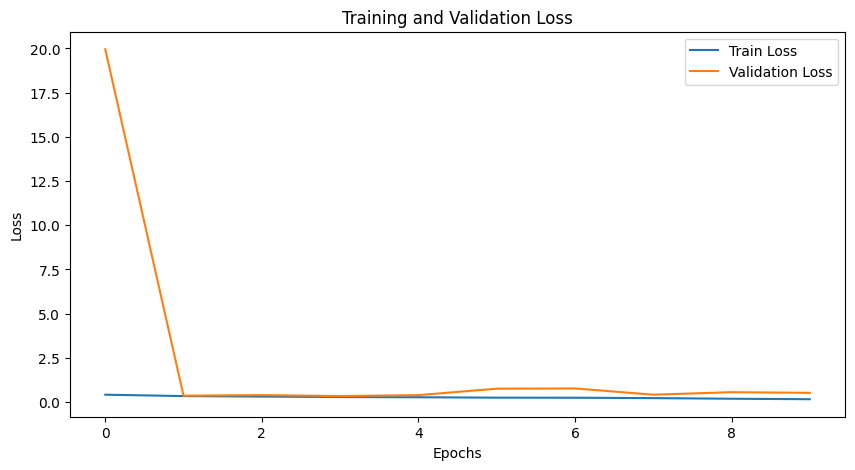

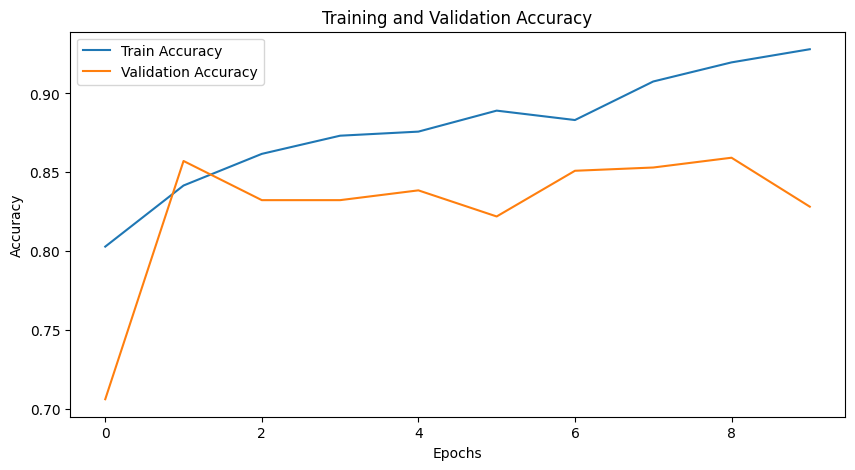

In [36]:
# Evaluating the model on the test set
test_loss, test_accuracy = evaluate_model(
    model=resnet_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Visualize results
# Visualize training and validation performance

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('2 - Training and Validation Loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('2 - Training and Validation Accuracy')
plt.show()

### Save Model

In [48]:
PATH = r"CNNmodels\resnet_weights.pt"
torch.save(resnet_model.state_dict(), PATH)

### Test for unknown data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].


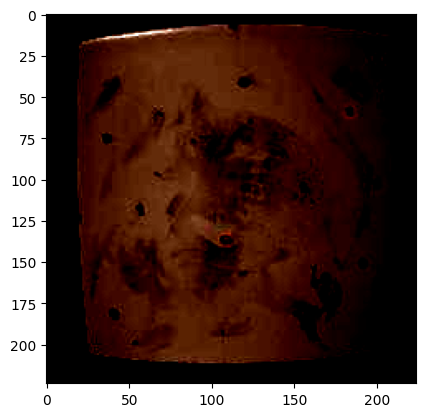

Correct labels: [0 0 1]
Raw predicted scores: [[ -4.238361 -13.837447  11.55397 ]]
Sigmoid probabilities: [[1.4225928e-02 9.7830139e-07 9.9999034e-01]]
Binary predicted labels: [[0 0 1]]


In [53]:
input, label = test_dataset[0]

# Convert tensor to numpy array 
image = input.numpy().transpose((1,2,0))[:, :, ::-1]

# Display image
plt.imshow(image)
plt.show()

# Start predicting
resnet_model.eval()
input = input.to(device) # move inputs to gpu
# Forward pass
with torch.no_grad():
    predicted = resnet_model(input.unsqueeze(0))
    sigmoid_predicted = torch.sigmoid(predicted)
    binary_predicted = (sigmoid_predicted > 0.3).int() # Threshold

predicted = predicted.cpu().numpy() # remove from computational graph to cpu and as numpy
sigmoid_predicted = sigmoid_predicted.cpu().numpy()
binary_predicted = binary_predicted.cpu().numpy()

#  Display results
print(f"Correct labels: {label.numpy()}")  # Convert label tensor to numpy for consistency
print(f"Raw predicted scores: {predicted}")
print(f"Sigmoid probabilities: {sigmoid_predicted}")
print(f"Binary predicted labels: {binary_predicted}")

## Transform image to model readable format


In [67]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (compatible with ResNet)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained ResNet
    ])
    image = Image.open(image_path).convert('RGB')
    preprocessed_image = preprocess(image)
    return preprocessed_image

def predict_image(model, preprocessed_input, device):
    model.eval()
    with torch.no_grad():
        preprocessed_input = preprocessed_input.to(device)
        output = model(preprocessed_input.unsqueeze(0))
        sigmoid_output = torch.sigmoid(output)
        binary_output = (sigmoid_output > 0.3).int()
        binary_output = binary_output.cpu().numpy()
        return binary_output
    
def convert_output_to_string(output, class_labels):
    for i in np.ptp(output):
        print(i)

In [30]:
# Load model
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = r"CNNmodels\resnet_weights.pt"

resnet_model = models.resnet18(pretrained=True)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_features, num_classes)
)

resnet_model.to(device)
resnet_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

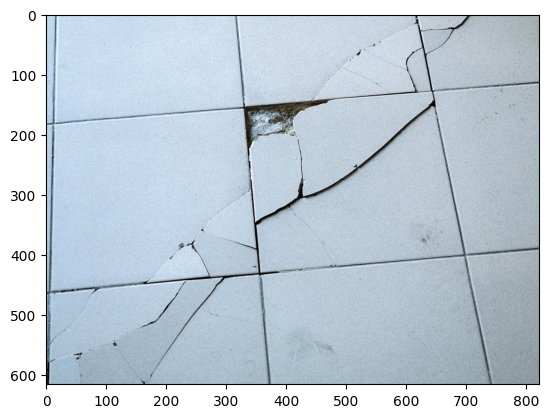

In [45]:
# Predict unknown data
test_img_path = r"crack_tiles.png"
testImage = img.imread(test_img_path)
plt.imshow(testImage)
p_input = preprocess_image(test_img_path)

In [68]:
c_labels = ['Crack', 'Scratch', 'Stain']
output = (predict_image(resnet_model, preprocessed_input=p_input, device=device))
convert_output_to_string(output=output, class_labels=c_labels)

TypeError: 'numpy.int32' object is not iterable